In [1]:
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
import uproot as up
import pandas as pd 
import awkward as ak
from numba_stats import crystalball,crystalball_ex, norm, expon, voigt, truncexpon
import os, sys
import yaml
import xgboost as xgb
from sklearn.model_selection import train_test_split

os.environ["HOMELUDO"]="/home/submit/mori25/"
os.environ["DPUSER"]="/work/submit/mori25/Darkphotons_ludo/offline_analysis/"
sys.path.append('/work/submit/mori25/Darkphotons_ludo/offline_analysis/BDT')
sys.path.append('/work/submit/mori25/Darkphotons_ludo/offline_analysis/utils')

from systematics import Systematics as Sys

def load_analysis_config():
    try:
        with open(os.path.join(os.environ["DPUSER"],"config/analysis_config.yml"), "r") as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        return config

    except Exception as e: 
        raise e
    
config = load_analysis_config()

fYMC = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_MC1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays(cut="(HLT_Dimuon10_Upsilon_y1p4==1)")
fYData = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_data1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays( cut="(HLT_Dimuon10_Upsilon_y1p4==1 )")


# fY1MC = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_MC1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays(cut="(HLT_DoubleMu4_3_LowMass==0) & (abs(Mm_kin_eta)<6)")
# fY1Data = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_data1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays( cut="(HLT_DoubleMu4_3_LowMass==0 ) & (abs(Mm_kin_eta)<6)")
# fYMC = fYMC[abs(fYMC["Mm_kin_eta"])<6]
# fYData = fYData[abs(fYData["Mm_kin_eta"])<6]

fJpsiMC = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Jpsi_MC1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays(cut="HLT_DoubleMu4_3_LowMass==1")
fJpsiData = up.open(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Jpsi_data1M.root:RooTreeDataStore_dataWithSWeights_data_full")).arrays(cut="HLT_DoubleMu4_3_LowMass==1")

Study efficiency of the BDT forest_prompt_Jpsi on the Jpsi peak
ID cut: -100.4
BDT cut: 0.8
Total data signal yield:  678513.5694955434
Total MC signal yield:  531725 


bkg Yield_after_cut: 0.25
signal Yield_after_cut: 0.54
prompt signal Yield_after_cut: 0.81
MCYield_after_cut: 0.52 


MC corr Yield_after_cut 0.87 


BDT efficiency on Y peak: 
 On unfolded signal: 0.5401108946263582 
 On prompt corrected, unfolded signal: 0.8074369567547631 
 On MC: 0.521335276693778 
 On corrected MC: 0.866306169196337
Efficiency difference: 0.05886921244157384


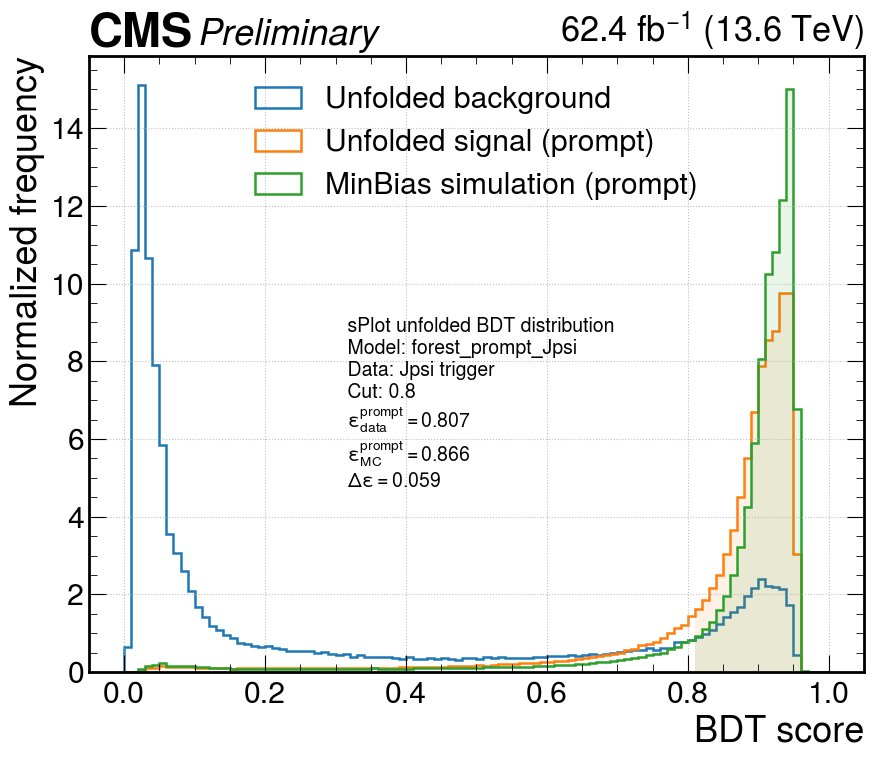

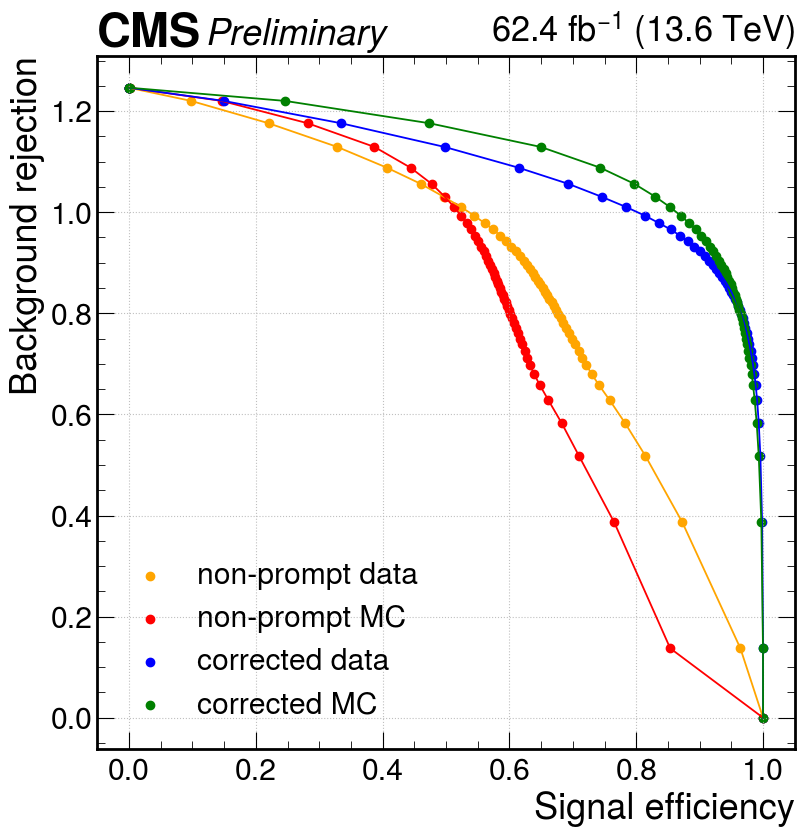

working point :  0.80008008008008


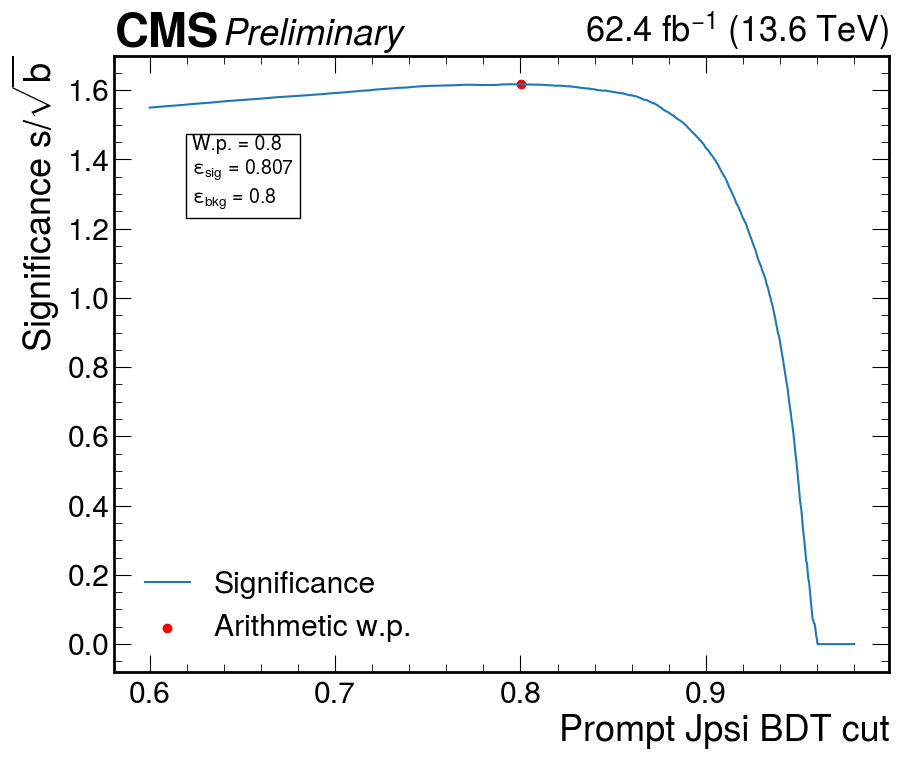

working point :  0.3441441441441442


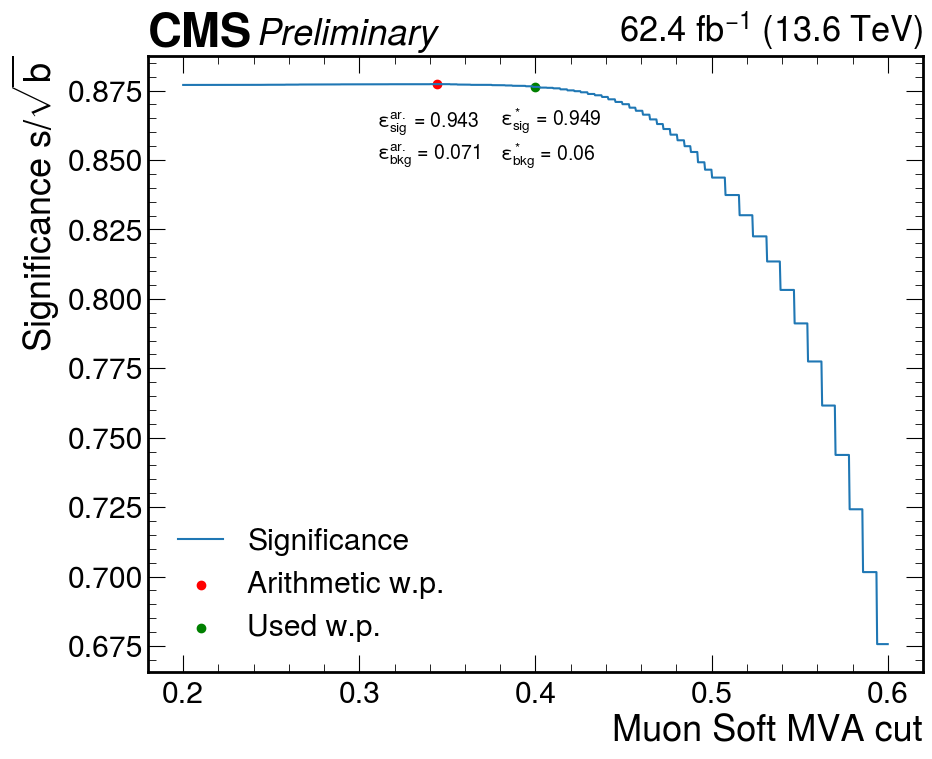

In [2]:
s=Sys(fJpsiData,fJpsiMC,0.8,-100.4,"Jpsi")
s.study_efficiency("forest_prompt_Jpsi",None)
s.plot(plot_nonPrompt=False,plot_corr=True,plot_bkg=True)
Jpsi_on_Jpsi=s.plot_ROC()
s.study_significance("mva")
s.study_significance("ID") #make sure you remove the ID cut when you do this

Text(0.1, 0.45, 'Cut point (tuned) = 2.5\n$\\varepsilon_{sig}^{t}$ = 2.3 \n$\\varepsilon_{bkg}^{t}$ =')

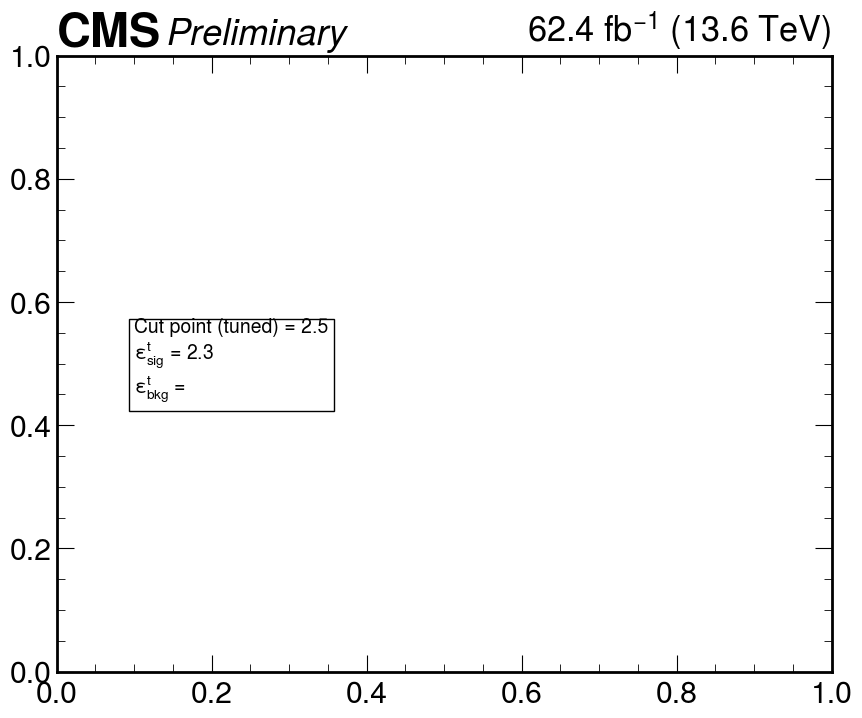

In [3]:
a = fr"""Cut point (tuned) = {round(2.5,3)}
$\varepsilon_{{sig}}^{{t}}$ = {round(2.3,3)} 
$\varepsilon_{{bkg}}^{{t}}$ ="""
import mplhep as hep

hep.style.use("CMS")
plt.figure(figsize=(10, 8))
hep.cms.label("Preliminary",data=True,lumi=config["lumi"]["offline"], com=config["com"])
ax = plt.gca()
plt.text(0.1,0.45,a, fontsize=14, bbox=dict(facecolor='white', edgecolor='black'),transform=ax.transAxes) 

In [4]:

branches = {"Mm_kin_lxy":{'t': 'f','l' : (0,0.2)},
            "Mm_mass":{'t':'f','l':(2.6,3.56)},
            # "Muon_softMva1":{'t': 'f','l' : (-1,1)},
            # "Muon_softMva2":{'t': 'f','l' : (-1,1)},
            "Mm_kin_l3d":{'t': 'f','l' : (0,0.2)},
            "Mm_iso":{'t': 'f','l' : None},
            
            "Mm_kin_vtx_chi2dof":{'t': 'f','l' : (0,20)},
            "Mm_kin_vtx_prob":{'t': 'f','l' : (0,1)},
            "Mm_kin_alpha":{'t': 'f','l' : (0,np.pi)},
            "Mm_kin_alphaBS":{'t': 'f','l' : (0,np.pi)},
            "Mm_closetrk":{'t': 'i','l' : (0,10)},
            "Mm_closetrks1":{'t': 'i','l' : (0,80)},
            "Mm_closetrks2":{'t': 'i','l' : (0,120)},
            "Mm_kin_pvip":{'t': 'f','l' : (0,0.05)},
            "Mm_kin_spvip":{'t': 'f','l' : (0,20)},
            # "Mm_m1iso":{'t': 'f','l' : (0,1)},
            # "Mm_m2iso":{'t': 'f','l' : (0,1)},
            "Mm_kin_sl3d":{'t': 'f','l' : (0,20)},
            # "Mm_nDisTrks":{'t': 'i','l' : (0,8)},
            # "Mm_mu1_pt":{'t': 'f','l' : (0,20)},
            # "Mm_mu2_pt":{'t': 'f','l' : (0,20)},
            # "Mm_kin_pt":{'t': 'f','l' : (0,40)},
            # "Mm_mu2_eta":{'t': 'f','l' :None},
            # "Mm_docatrk":{'t': 'i','l' : (0,8)},    
            "Mm_kin_eta":{'t': 'f','l' :None},    
            # "Mm_mu1_eta":{'t': 'f','l' :None},    
            # "Mm_mu2_eta":{'t': 'f','l' :None},    
            "Mm_kin_pvlip":{'t': 'f','l' :(0,0.1)},
            "Mm_otherVtxMaxProb":{'t': 'f','l' :(0.8,1)},
            "Mm_otherVtxMaxProb1":{'t': 'f','l' :(0.8,1)},
            "Mm_otherVtxMaxProb2":{'t': 'f','l' :(0,1)},
            # "Mm_mva":{'t': 'f','l' :(-0.2,0.2)}
            }

Mm_kin_lxy  done


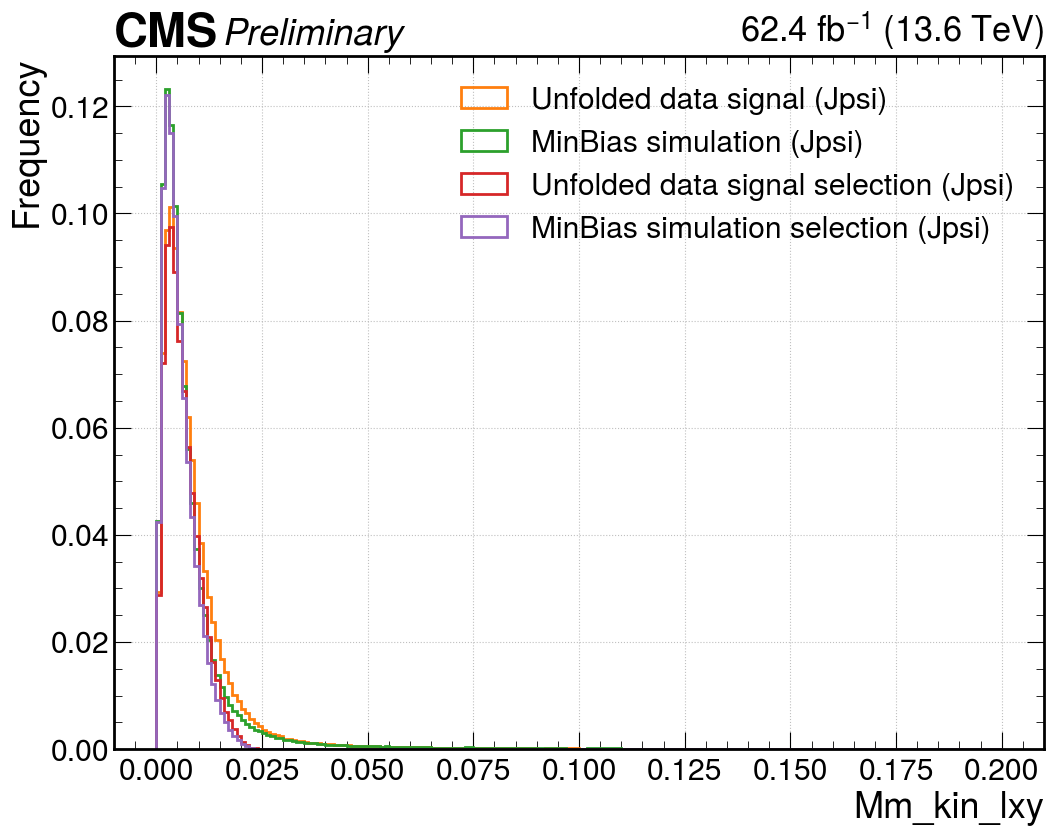

Mm_mass  done


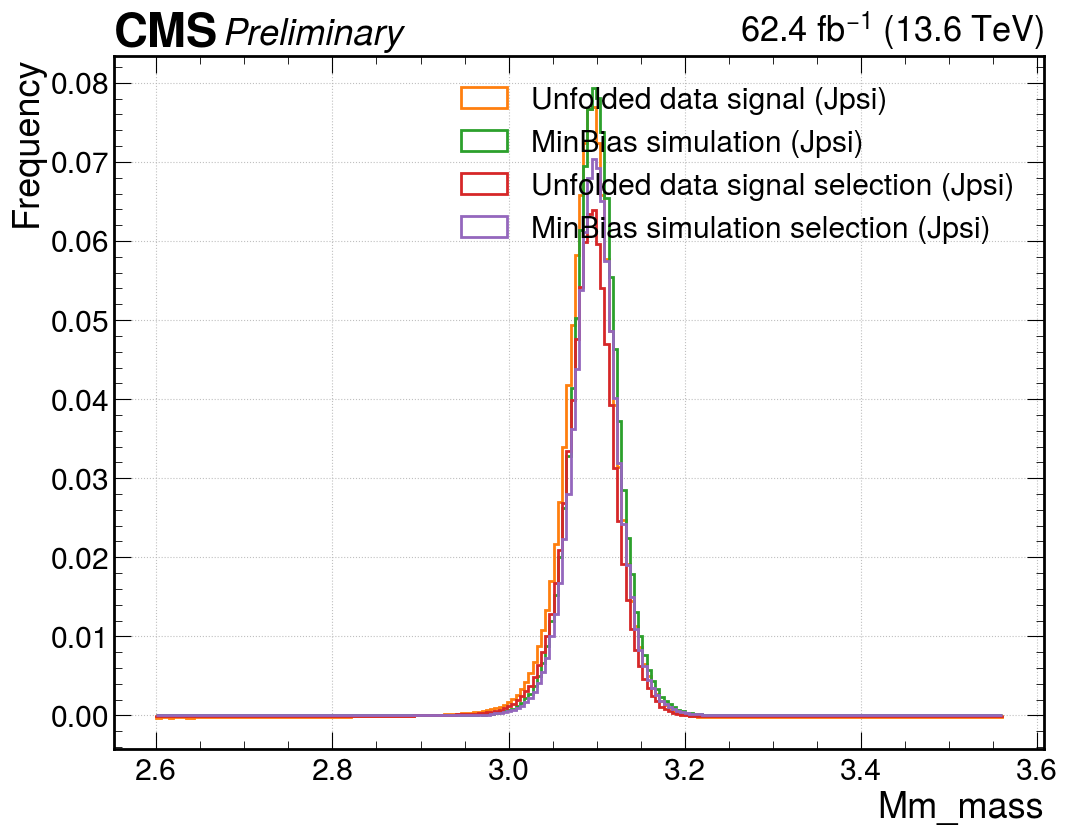

Mm_kin_l3d  done


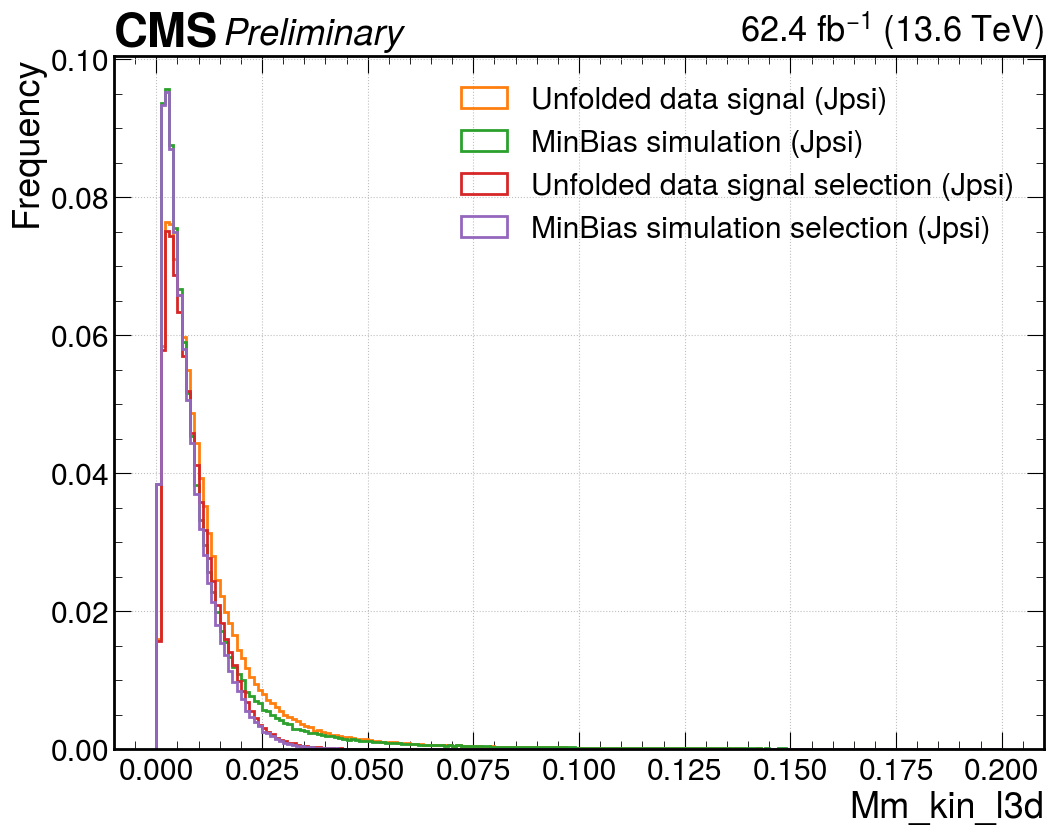

Mm_iso  done


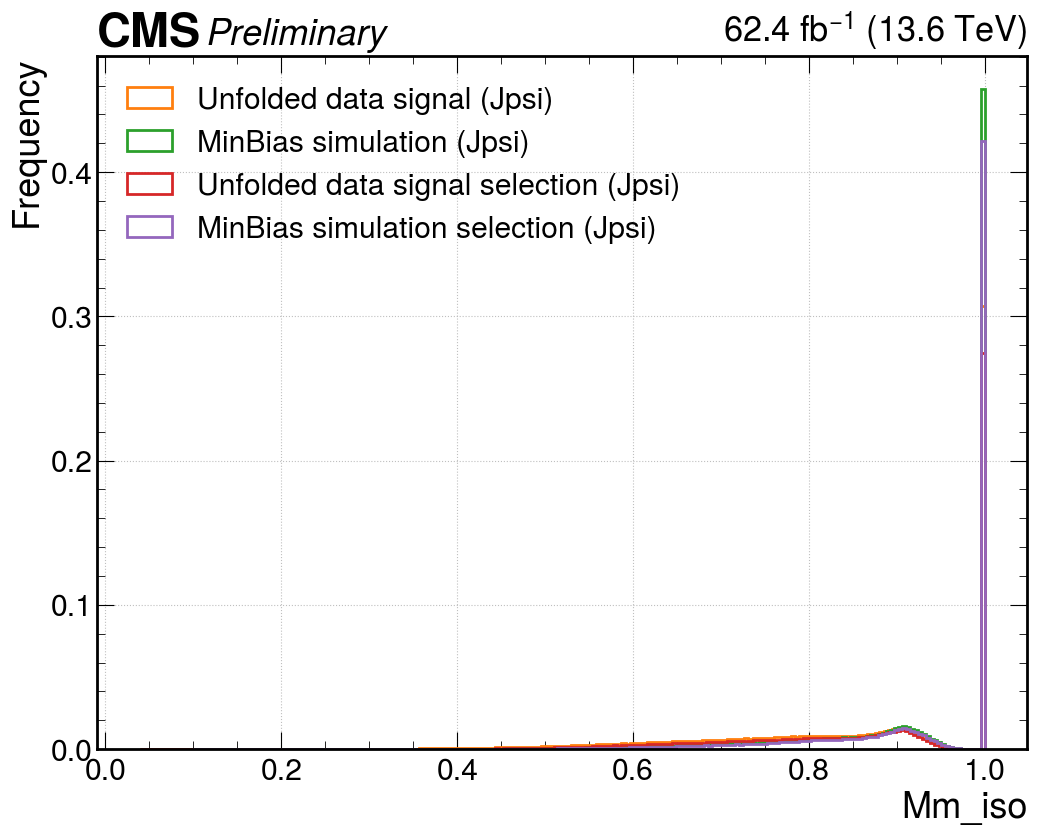

Mm_kin_vtx_chi2dof  done


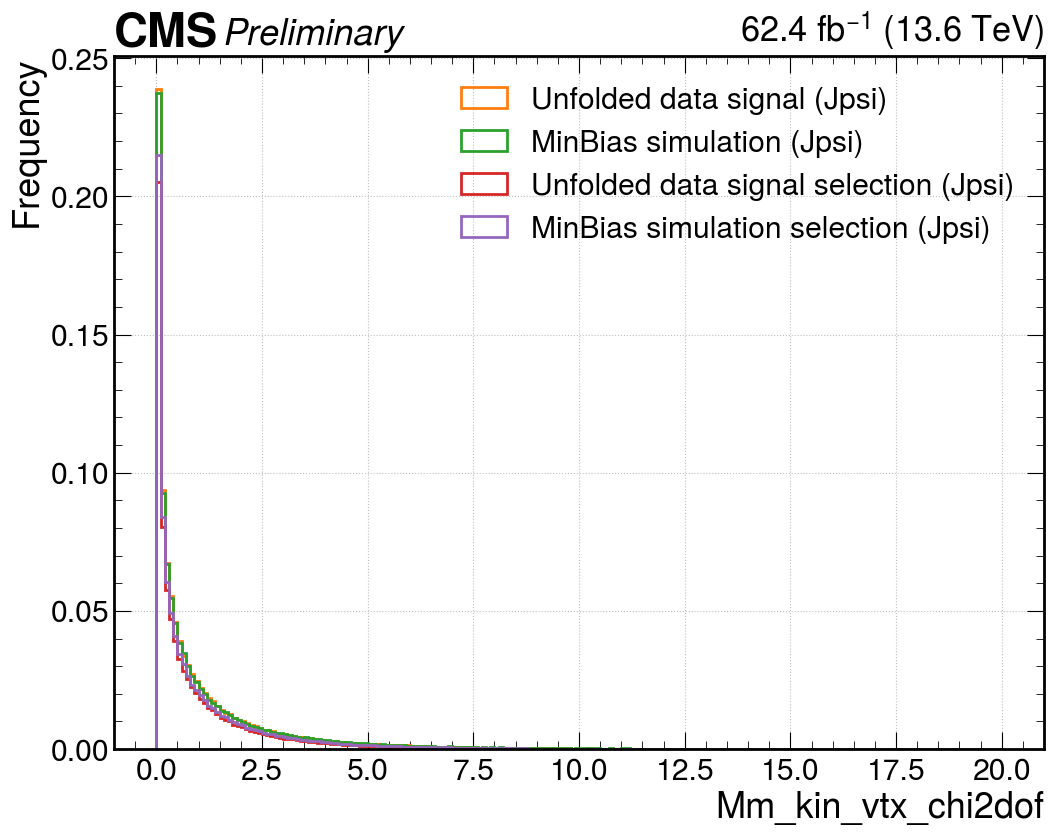

Mm_kin_vtx_prob  done


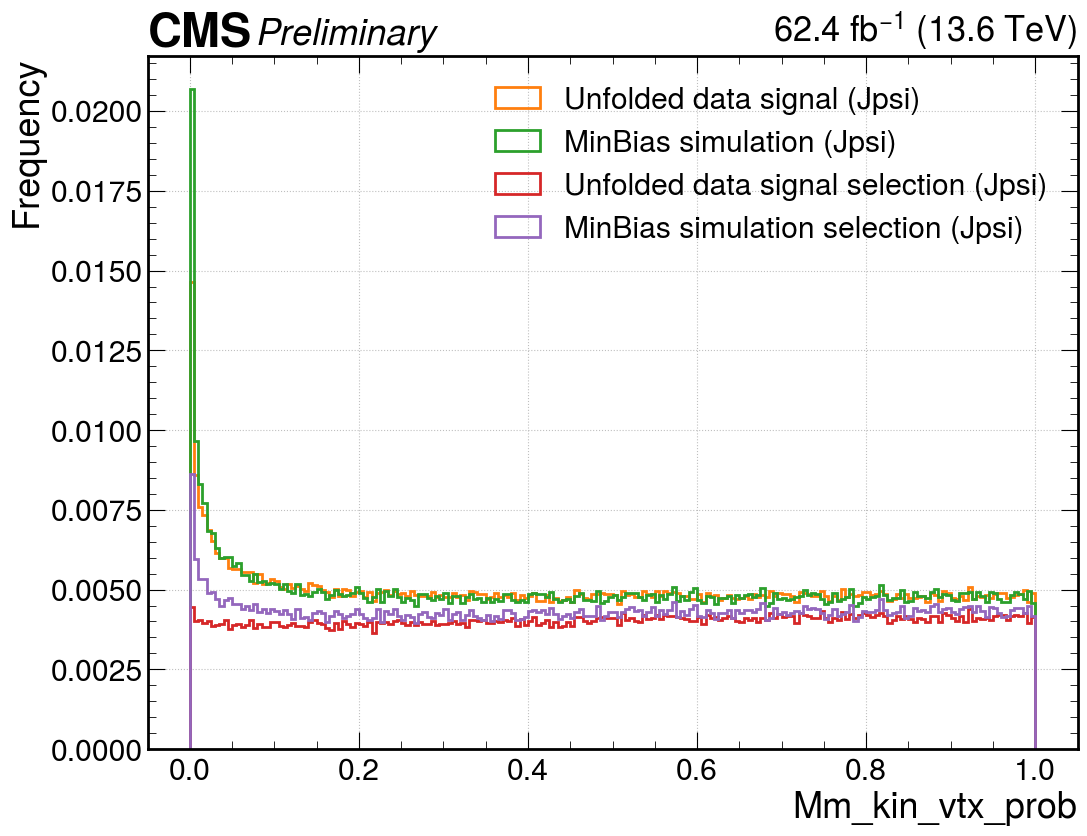

Mm_kin_alpha  done


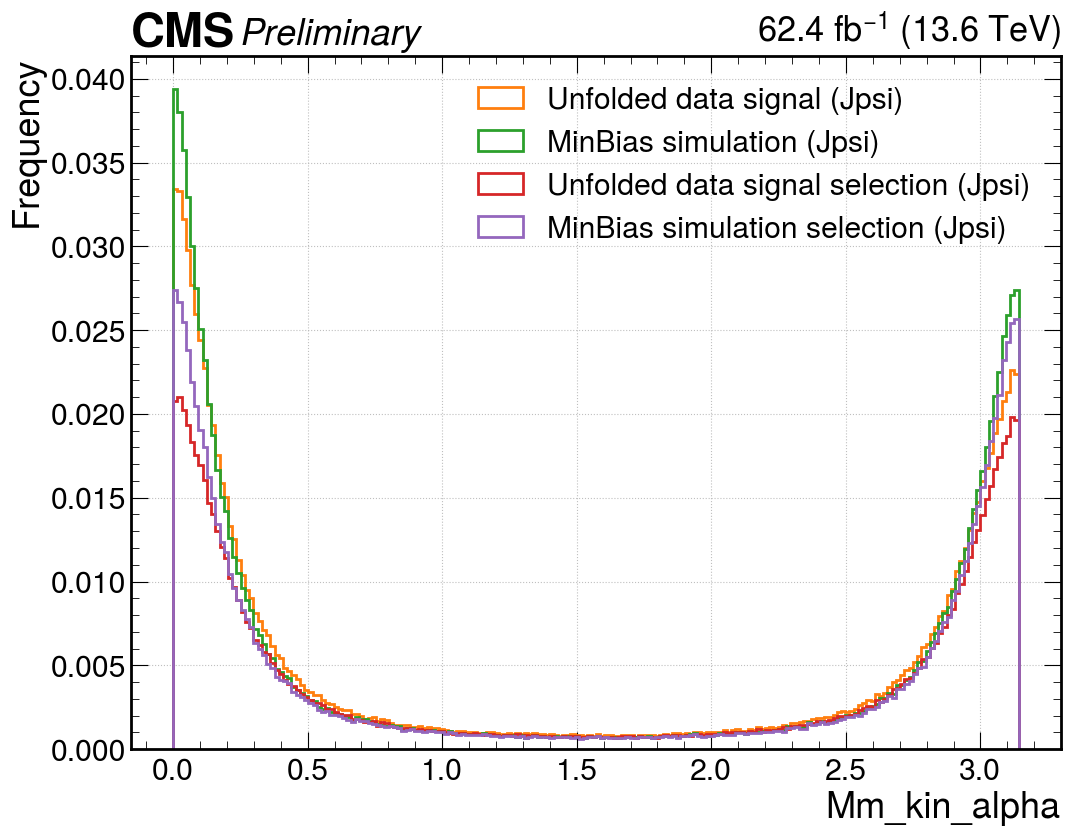

Mm_kin_alphaBS  done


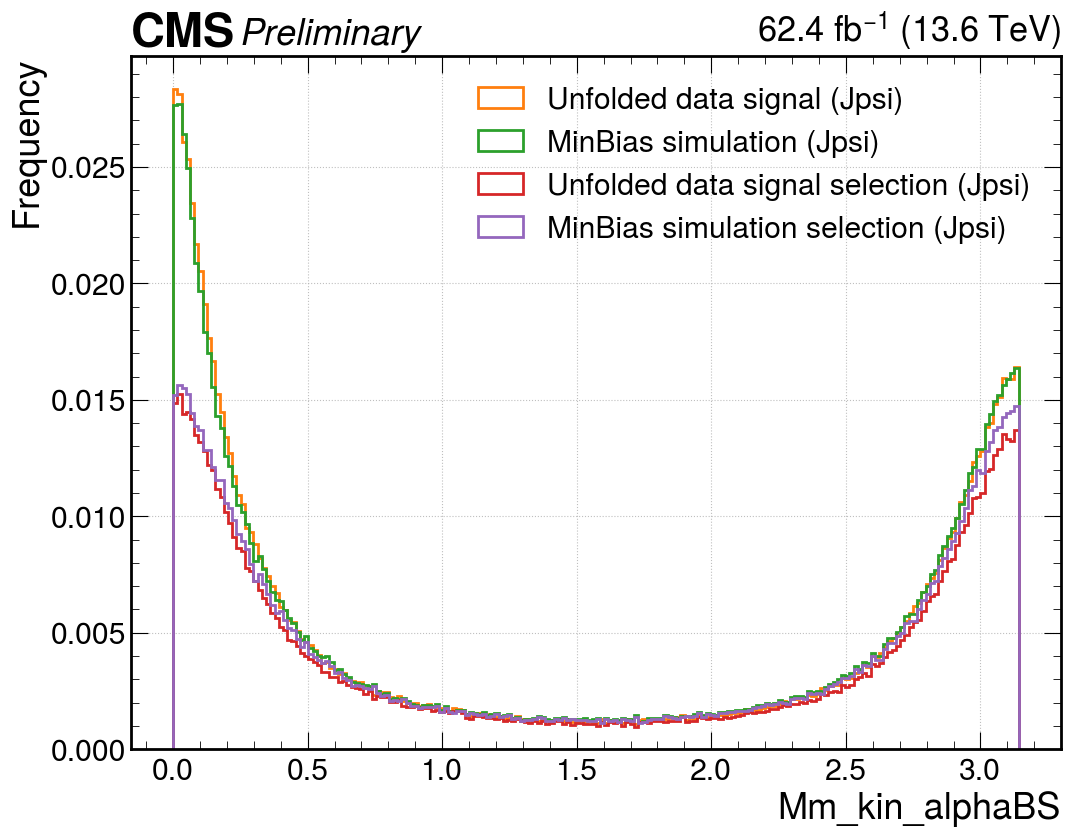

Mm_closetrk  done


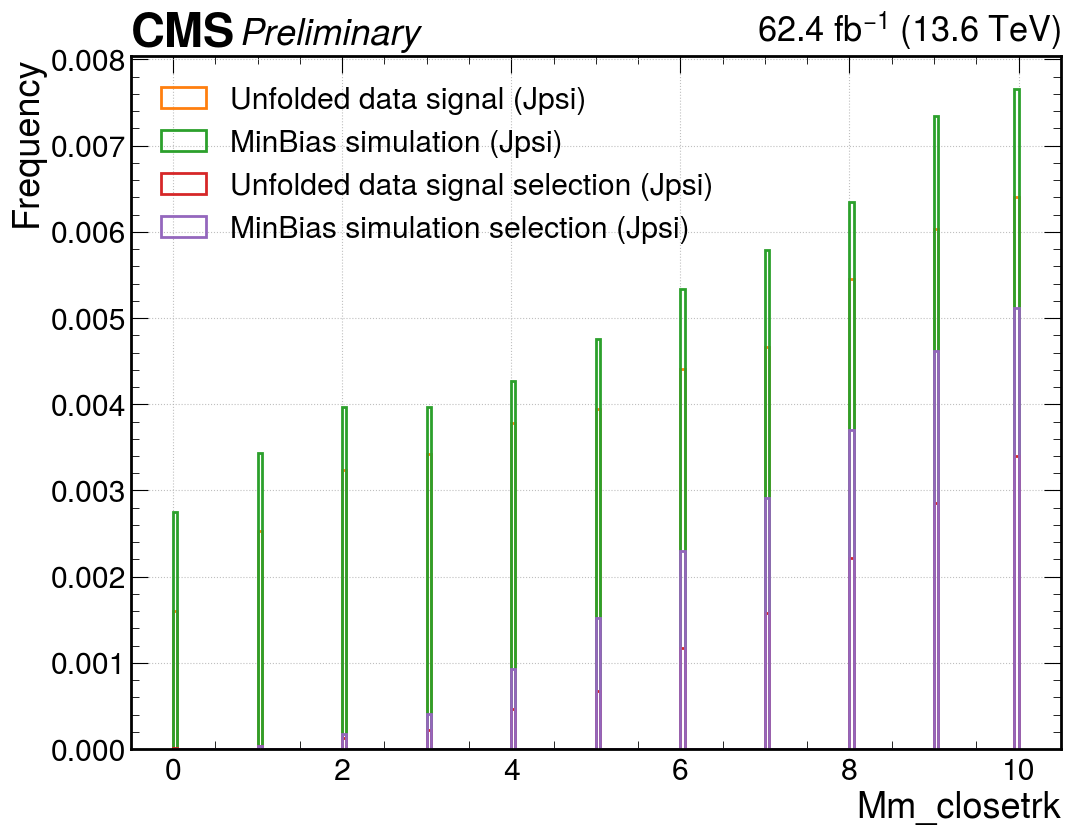

Mm_closetrks1  done


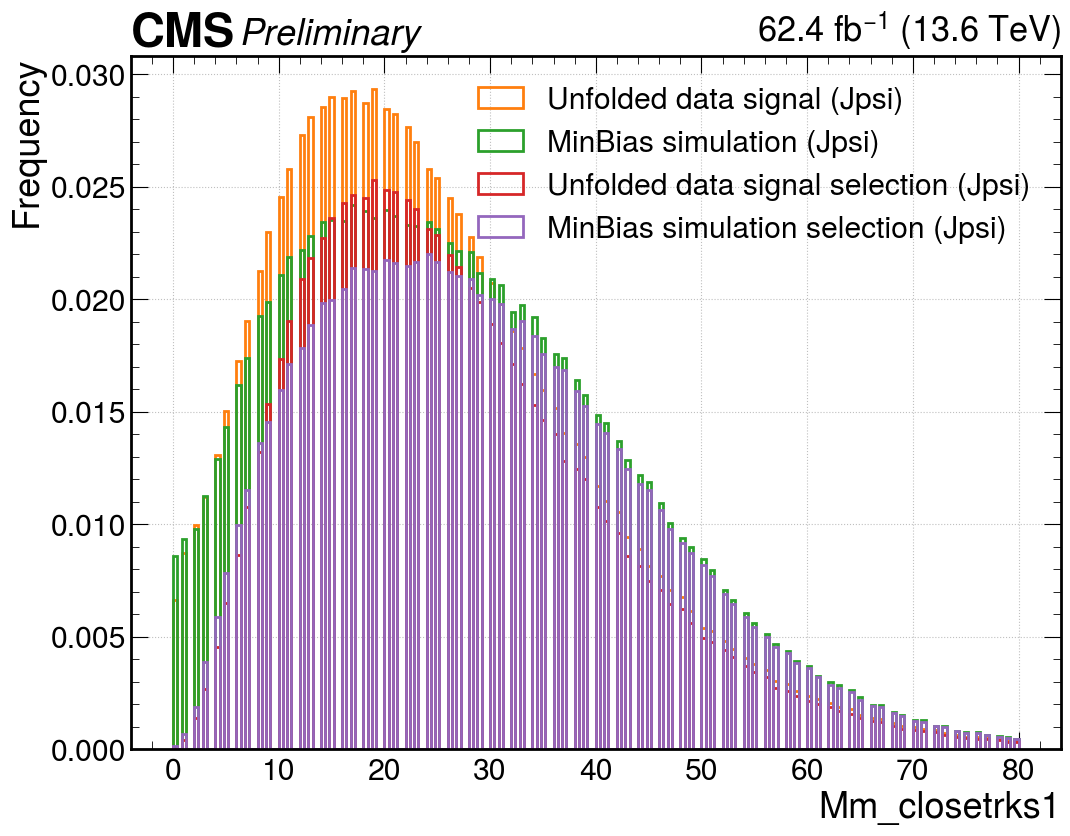

Mm_closetrks2  done


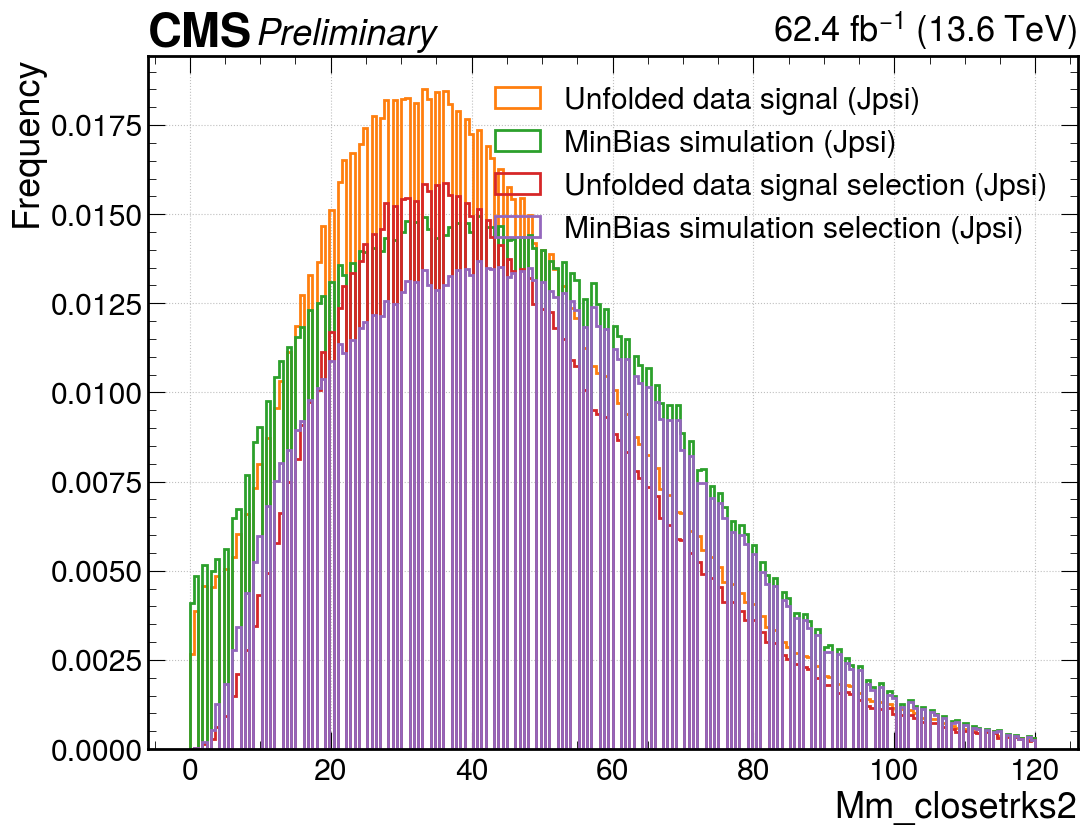

Mm_kin_pvip  done


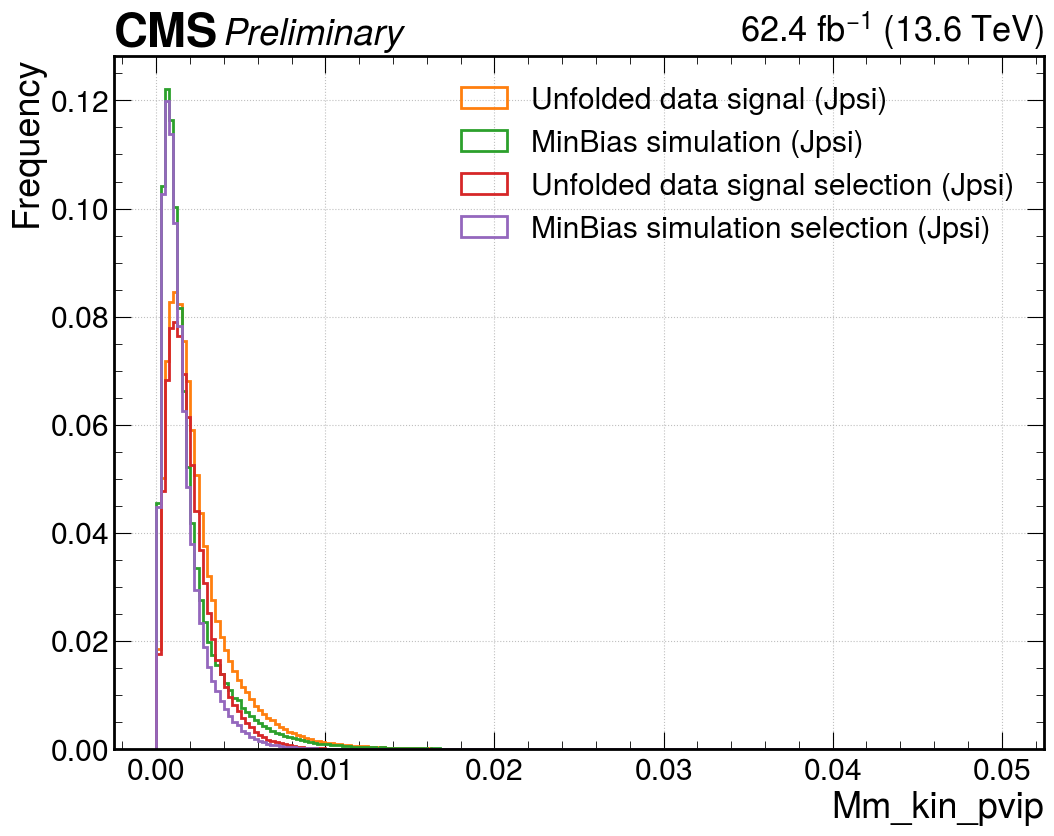

Mm_kin_spvip  done


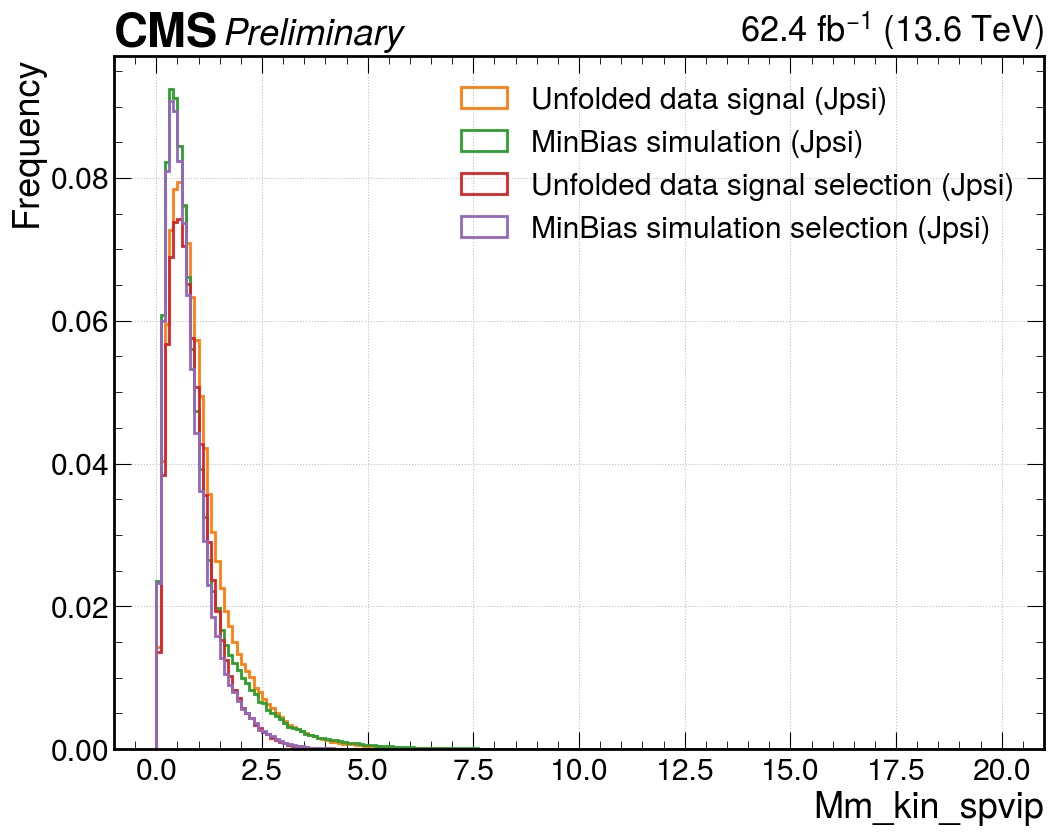

Mm_kin_sl3d  done


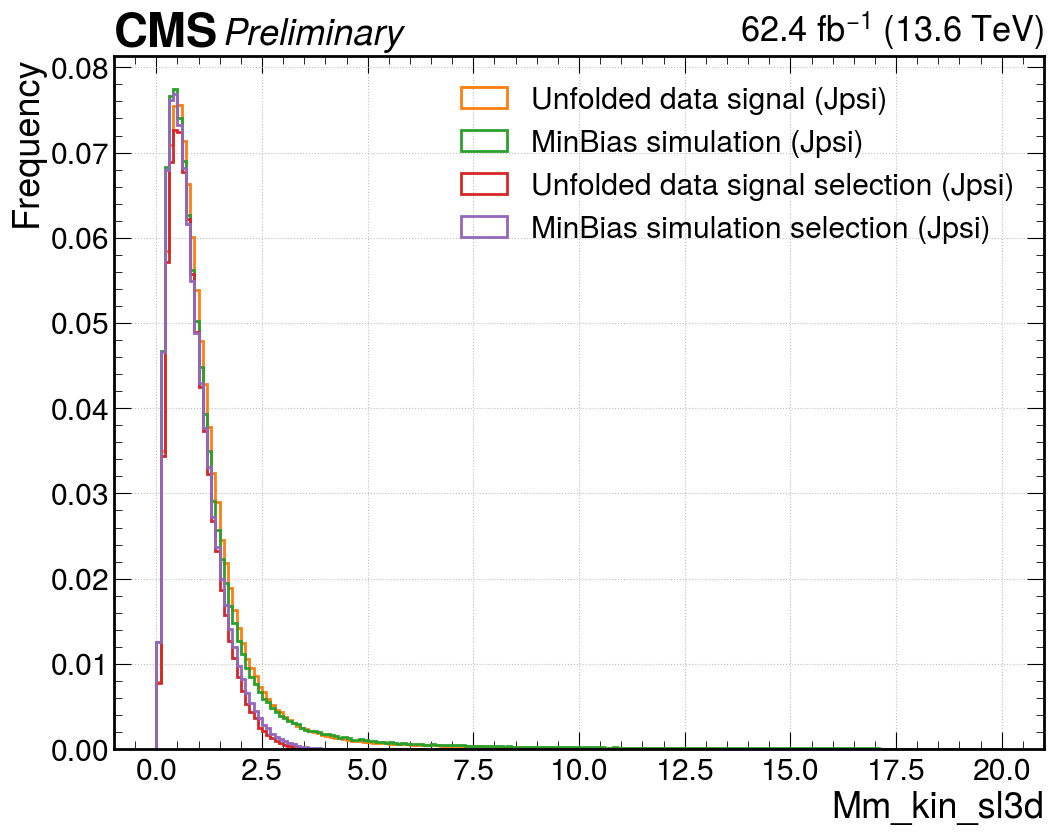

Mm_kin_eta  done


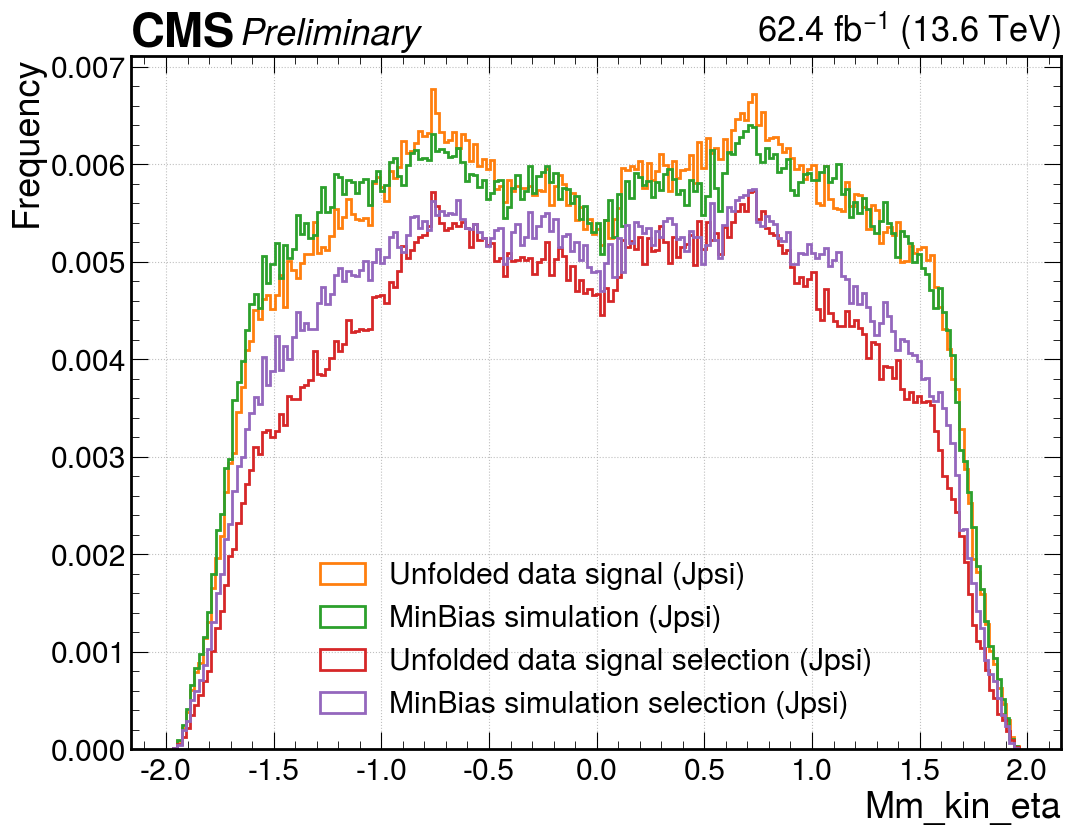

Mm_kin_pvlip  done


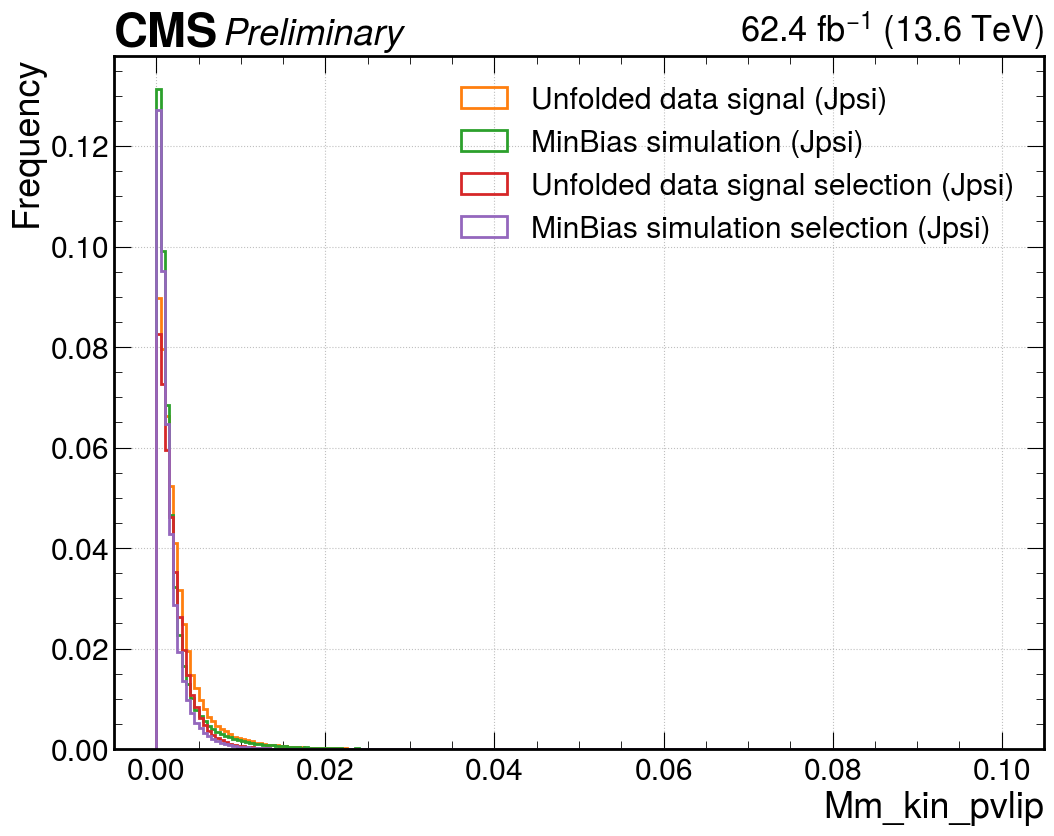

Mm_otherVtxMaxProb  done


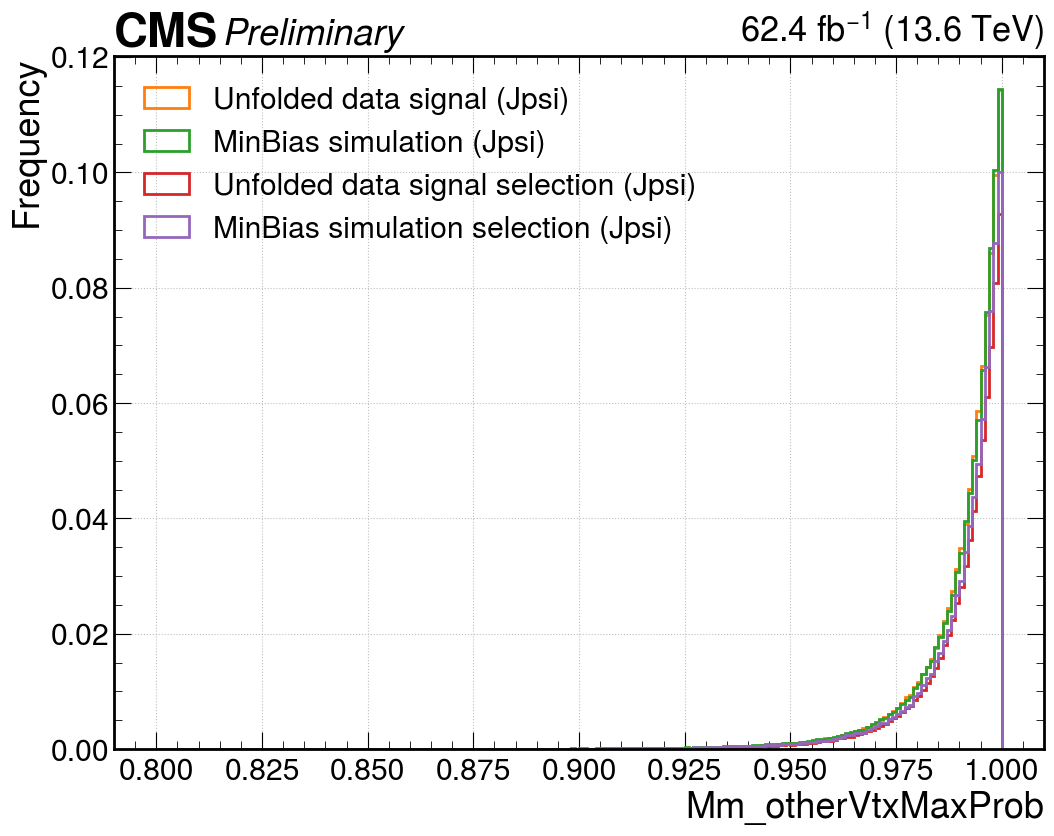

Mm_otherVtxMaxProb1  done


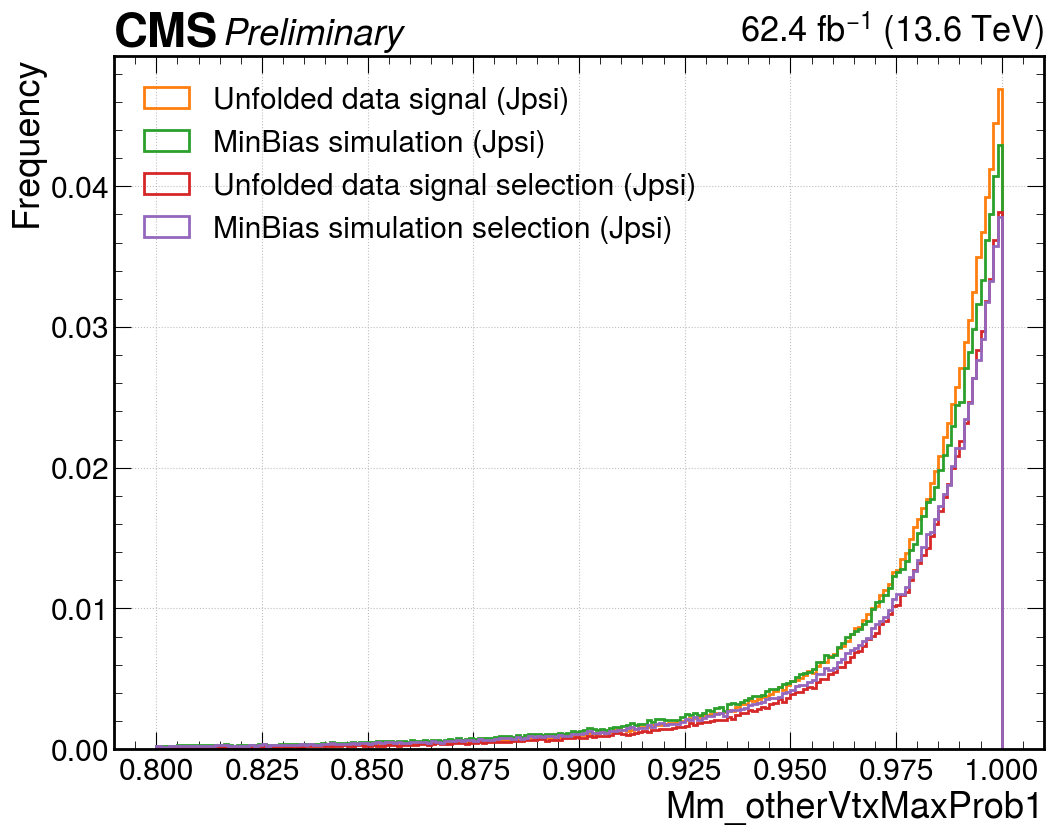

Mm_otherVtxMaxProb2  done


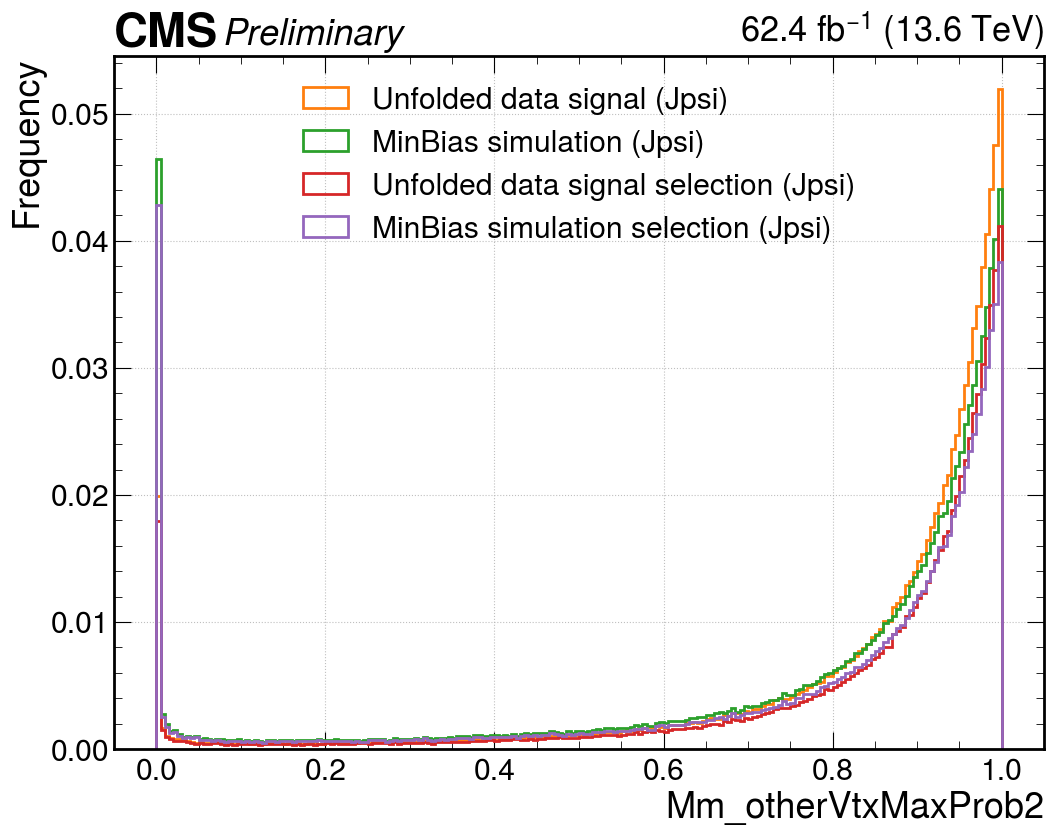

In [5]:
s.plot_quantities(branches,plot_selection=True)

In [6]:
# s=Sys(fJpsiData,fJpsiMC,"Jpsi")
# s.define_cuts(0.4448979591836735,-2)
# # s.compute_corrections_MC("Mm_kin_eta",hist_range=(-6,6),plot=False)
# s.study_efficiency("forest_standard_Y",None)
# s.plot(plot_bkg=True,plot_nonPrompt=True)
# Y_on_Jpsi=s.plot_ROC()


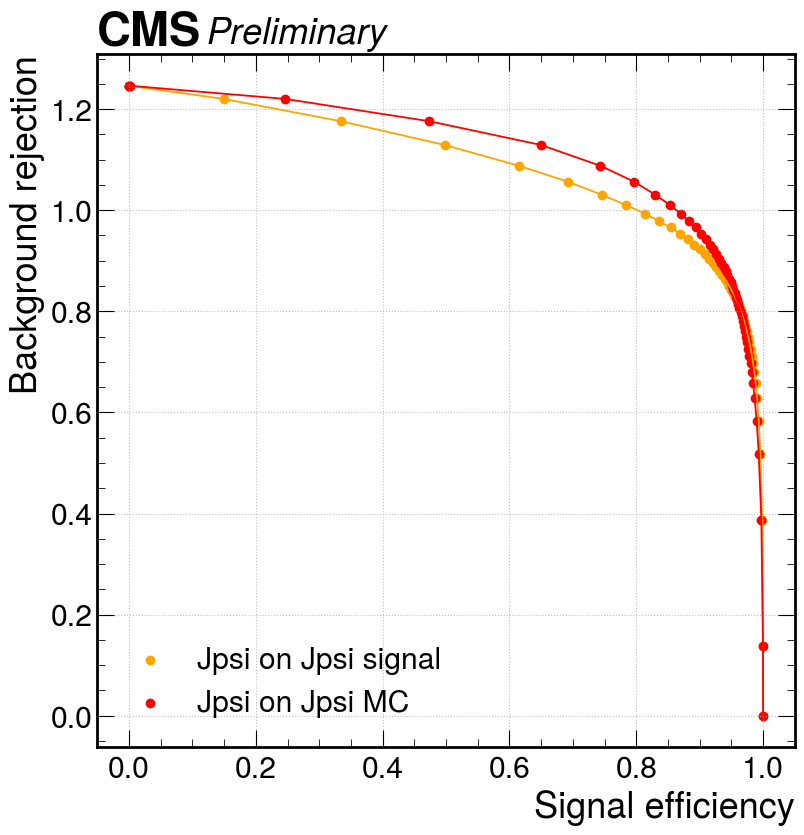

In [7]:
hep.style.use("CMS")
c = ["orange","red","blue","green"]
fig, ax = plt.subplots(figsize=(9,9))
hep.cms.text("Preliminary")

ax.scatter(Jpsi_on_Jpsi["corrected data"][0], Jpsi_on_Jpsi["corrected data"][1], color =c[0], zorder=0, label = "Jpsi on Jpsi signal")
ax.plot(Jpsi_on_Jpsi["corrected data"][0], Jpsi_on_Jpsi["corrected data"][1], lw=1.3, color = c[0])

ax.scatter(Jpsi_on_Jpsi["corrected MC"][0], Jpsi_on_Jpsi["corrected MC"][1], color =c[1], zorder=0, label = "Jpsi on Jpsi MC")
ax.plot(Jpsi_on_Jpsi["corrected MC"][0], Jpsi_on_Jpsi["corrected MC"][1], lw=1.3, color = c[1])

# ax.scatter(Y_on_Jpsi["corrected data"][0], Y_on_Jpsi["corrected data"][1], color =c[2], zorder=0, label = "Y on Jpsi signal")
# ax.plot(Y_on_Jpsi["corrected data"][0], Y_on_Jpsi["corrected data"][1], lw=1.3, color = c[2])

# ax.scatter(Y_on_Jpsi["corrected MC"][0], Y_on_Jpsi["corrected MC"][1], color =c[3], zorder=0, label = "Y on Jpsi MC")
# ax.plot(Y_on_Jpsi["corrected MC"][0], Y_on_Jpsi["corrected MC"][1], lw=1.3, color = c[3])
        
ax.set_xlabel('Signal efficiency')
ax.set_ylabel('Background rejection')
ax.grid(True)
ax.legend()
plt.show()

Study efficiency of the BDT forest_prompt_Jpsi on the Y peak
ID cut: 0.4
BDT cut: 0.8
Total data signal yield:  426546.7173372141
Total MC signal yield:  32721 


bkg Yield_after_cut: 0.65
signal Yield_after_cut: 0.95
prompt signal Yield_after_cut: 0.95
MCYield_after_cut: 0.96 


MC corr Yield_after_cut 0.96 


BDT efficiency on Y peak: 
 On unfolded signal: 0.9505318832561654 
 On prompt corrected, unfolded signal: 0.9505318832561752 
 On MC: 0.9629901286635127 
 On corrected MC: 0.9629901286637865
Efficiency difference: 0.012458245407611312


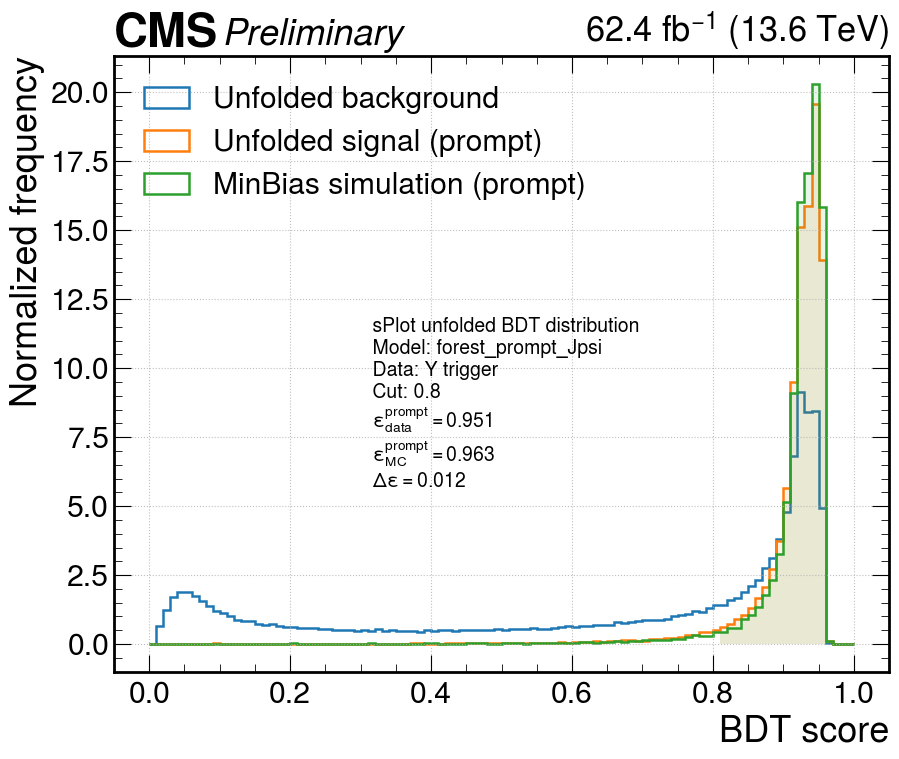

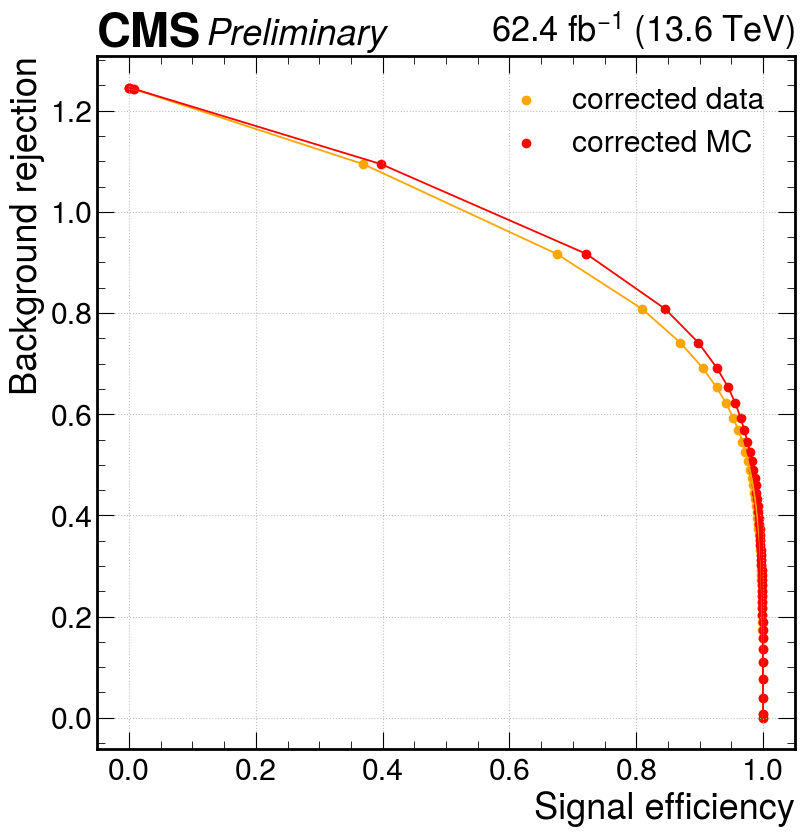

In [8]:
s=Sys(fYData,fYMC,0.8,0.4,"Y")
# s.compute_corrections_MC("Mm_kin_eta",hist_range=(-6,6),plot=True)
s.study_efficiency("forest_prompt_Jpsi")
s.plot(plot_corr=True,plot_nonPrompt=False,plot_bkg=True)
Jpsi_on_Y = s.plot_ROC(plot_corr=True,plot_nonPrompt=False)

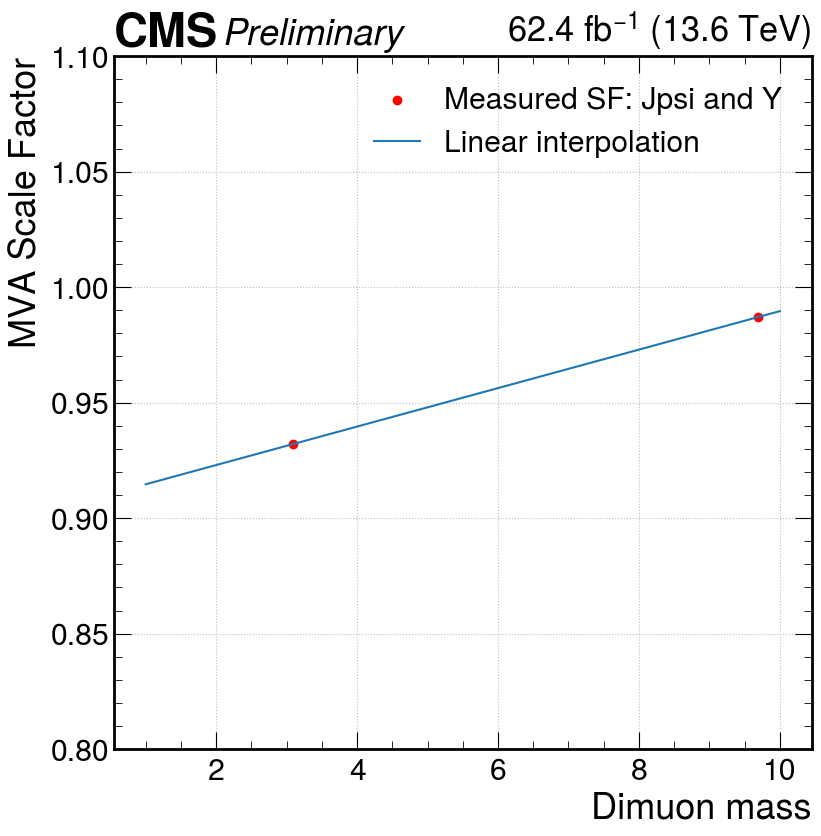

In [9]:
#make a nice plot of a line with coefficients m,q

hep.style.use("CMS")
c = ["orange","red","blue","green"]
fig, ax = plt.subplots(figsize=(9,9))
hep.cms.label("Preliminary",data=True,lumi=config["lumi"]["offline"],com=config["com"])


mass_Jpsi = 3.0943
mass_Y1 = 9.451
mass_Y2 = 10.015
mass_Y3 = 10.345

Y2_frac = 0.2173
Y3_frac = 0.1367
Y1_frac = 1 -Y2_frac - Y3_frac

mass_Y = Y1_frac*mass_Y1+ Y2_frac*mass_Y2 + Y3_frac*mass_Y3

SF_Jpsi = 0.8074369567547631/0.8662678497350005
SF_Y = 0.9505318832561752/0.9629901286637865
plt.scatter( [mass_Jpsi, mass_Y], [SF_Jpsi, SF_Y], label='Measured SF: Jpsi and Y',color='red')


m = (SF_Jpsi - SF_Y) / (mass_Jpsi - mass_Y)
q = - m*mass_Jpsi + SF_Jpsi

x = np.linspace(1, 10, 1000)
y = np.polyval([m, q], x)


plt.plot(x, y,label='Linear interpolation')
ax.set_ylim(0.8, 1.1)
plt.xlabel('Dimuon mass')
plt.ylabel('MVA Scale Factor')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# s=Sys(fYData,fYMC,"Y")
# s.define_cuts(0.716,-2)
# s.compute_corrections_MC("Mm_kin_eta",hist_range=(-6,6),plot=True)
# s.study_efficiency("forest_standard_Y","Mm_kin_eta")
# s.plot(plot_corr=True,plot_nonPrompt=False,plot_bkg=True)
# Y_on_Y = s.plot_ROC(plot_corr=True,plot_nonPrompt=False,)


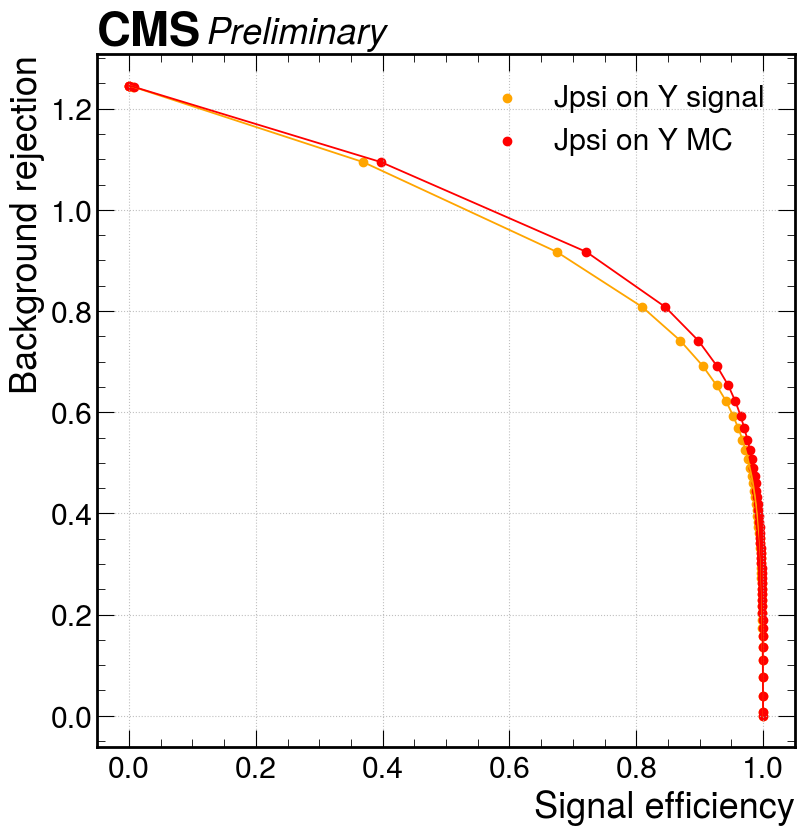

In [11]:
hep.style.use("CMS")
c = ["orange","red","blue","green"]
fig, ax = plt.subplots(figsize=(9,9))
hep.cms.text("Preliminary")

ax.scatter(Jpsi_on_Y["corrected data"][0], Jpsi_on_Y["corrected data"][1], color =c[0], zorder=0, label = "Jpsi on Y signal")
ax.plot(Jpsi_on_Y["corrected data"][0], Jpsi_on_Y["corrected data"][1], lw=1.3, color = c[0])

ax.scatter(Jpsi_on_Y["corrected MC"][0], Jpsi_on_Y["corrected MC"][1], color =c[1], zorder=0, label = "Jpsi on Y MC")
ax.plot(Jpsi_on_Y["corrected MC"][0], Jpsi_on_Y["corrected MC"][1], lw=1.3, color = c[1])

# ax.scatter(Y_on_Y["corrected data"][0], Y_on_Y["corrected data"][1], color =c[2], zorder=0, label = "Y on Y signal")
# ax.plot(Y_on_Y["corrected data"][0], Y_on_Y["corrected data"][1], lw=1.3, color = c[2])

# ax.scatter(Y_on_Y["corrected MC"][0], Y_on_Y["corrected MC"][1], color =c[3], zorder=0, label = "Y on Y MC")
# ax.plot(Y_on_Y["corrected MC"][0], Y_on_Y["corrected MC"][1], lw=1.3, color = c[3])
        
ax.set_xlabel('Signal efficiency')
ax.set_ylabel('Background rejection')
ax.grid(True)
ax.legend()
plt.show()

In [12]:
print(os.path.join(config["locations"]["sPlot"], "files/data_withSWeight_Y_MC.root:RooTreeDataStore_dataWithSWeights_data_full"))

/data/submit/mori25/dark_photons_ludo/DimuonTrees/sPlot/files/data_withSWeight_Y_MC.root:RooTreeDataStore_dataWithSWeights_data_full


In [13]:
def parse_text_file(filename):
    # Initialize an empty dictionary to store the results
    result_dict = {}
    
    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            
            name = ""
            i=0

            for line in lines:
                i+=1
                # Remove leading and trailing whitespace
                line = line.strip()
                
                # Check if the line is not empty and starts with a double-quote
                if line and line.startswith('"'):
                    # Split the line by double-quotes
                    name = line.split('"')[1]
                    i=0
                
                if (i==2): 
                    val = line.split('"')[0] 
                    # Add the string and number to the dictionary
                    result_dict[name] = float(val)
    
    except FileNotFoundError:
        print(f"The file '{filename}' was not found.")
    
    return result_dict


In [14]:

def plotPeak(mass,pars,components,range=None,title=None,plot_data=True):
    hep.style.use("CMS")
    cmap = plt.cm.tab10.colors
    fig, ax = plt.subplots(2,1,sharex = True,figsize=(12,9),gridspec_kw={'height_ratios': [2, 1]})

    w, xe = np.histogram(mass, bins=100, range = range)
    x = 0.5*(xe[:-1]+xe[1:])
    fine_x = np.linspace(x[0],x[-1],1000)
    werr = w ** 0.5
    dx = np.diff(xe)[0]

    names = components.keys()
    functions = [components[key] for key in names]

    ax[0].errorbar(x, w, werr, xerr=dx, fmt = 'o' , markersize = 3, capsize = 3, label="$m_{\mu\mu}^{off}$", color = "black", zorder=0)
    for f,name,color in zip(functions,names,cmap[:len(names)]):
        if (name=="Total"): ax[0].plot(fine_x, f(fine_x, *pars)*dx, lw=2, label=name, color = color, zorder=1)
        else: ax[0].plot(fine_x, f(fine_x, *pars)*dx, linestyle = '--', lw=1.5, label=name, color = color)

    ax[1].set_xlabel('Dimuon mass $m_{\mu\mu}$ [GeV]')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlim(range)
    # ax[0].set_ylim((0,1.2*dx*f(np.mean(globals()[peak+"_lims"]), *args)))
    ax[1].set_ylim(-1,1)
    ax[0].legend(title=title,fontsize=14,title_fontsize=16)
    ax[0].grid(True)

    # ax[1].errorbar(x, w/dx/pdf(x, *pars)[1], fmt = 's' ,  markersize = 4,capsize = 2, color = "blue")
    ax[1].errorbar(x, np.divide(ak.to_numpy(w)-dx*components["Total"](x, *pars), ak.to_numpy(w), out=np.zeros((nbins,)), where=ak.to_numpy(w) != 0), fmt = '.' , label =r"$\frac{data - fit}{data}$", markersize = 8,capsize = 2, color = "blue")
    ax[1].axhline(y=0, color='black', linestyle='--')
    ax[1].legend(loc="lower left", fontsize = 14,title_fontsize = 14)
    plt.subplots_adjust(hspace=0.)


jpsi_lims = 2.6,3.56
jpsi_args = ["bkgYield", "bkgDecayConst", "sigYield", "mu", "sigmaL", "alphaL", "nL", "sigmaR", "alphaR", "nR", "GaussFraction", "sigma"]
def jpsi_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  (bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
            )
def jpsi_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
def jpsi_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst)


Y_lims = 8.5,11.2
Y_MC_args = ["bkgYield", "bkgDecayConst", "sigYield", "mu", "sigmaL", "alphaL", "nL", "sigmaR", "alphaR", "nR", "GaussFraction", "sigma"]
def Y_MC_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  (bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
            )
def Y_MC_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  sigYield*((1-GaussFraction)*crystalball_ex.pdf(x,alphaL, nL, sigmaL,alphaR, nR,sigmaR,mu) + 
                    GaussFraction*norm.pdf(x,mu, sigma))
def Y_MC_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, mu, sigmaL, alphaL, nL, sigmaR, alphaR, nR, GaussFraction, sigma):
            return  bkgYield*truncexpon.pdf(x,jpsi_lims[0],jpsi_lims[1],0,-1/bkgDecayConst)


Y_args = ["bkgYield", "bkgDecayConst", "sigYield", "alpha",  "sigmaL", "sigmaR", "mu1","mu2","mu3", "sigma1","sigma2","sigma3", "n1","n2", "n3", "GaussFraction", "fracY2", "fracY3"]
def Y_dCB_pdf(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  (bkgYield*truncexpon.pdf(x,Y_lims[0],Y_lims[1],0,-1/bkgDecayConst) + 
                    sigYield*(
                            (1-fracY2-fracY3)*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n1, sigmaL,alpha, n1,sigmaR,mu1) + 
                            GaussFraction*norm.pdf(x,mu1, sigma1)) +
                            fracY2*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n2, sigmaL,alpha, n2,sigmaR,mu2) + 
                            GaussFraction*norm.pdf(x,mu2, sigma2)) +
                            fracY3*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n3, sigmaL,alpha, n3,sigmaR,mu3) + 
                            GaussFraction*norm.pdf(x,mu3, sigma3)))
                    )
def Y_dCB_pdf_sig(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  (sigYield*(
                            (1-fracY2-fracY3)*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n1, sigmaL,alpha, n1,sigmaR,mu1) + 
                            GaussFraction*norm.pdf(x,mu1, sigma1)) +
                            fracY2*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n2, sigmaL,alpha, n2,sigmaR,mu2) + 
                            GaussFraction*norm.pdf(x,mu2, sigma2)) +
                            fracY3*((1-GaussFraction)*crystalball_ex.pdf(x,alpha, n3, sigmaL,alpha, n3,sigmaR,mu3) + 
                            GaussFraction*norm.pdf(x,mu3, sigma3)))
                    )
def Y_dCB_pdf_bkg(x,  bkgYield, bkgDecayConst, sigYield, alpha, sigmaL, sigmaR, mu1,mu2,mu3,sigma1,sigma2,sigma3,n1,n2,n3, GaussFraction, fracY2,fracY3):
            return  bkgYield*truncexpon.pdf(x,Y_lims[0],Y_lims[1],0,-1/bkgDecayConst)
                    

In [15]:
filename = "SPlotJpsi_fit_MC_lxy.dot"
jpsi_MC_pars = parse_text_file(filename)
components = {"Total":jpsi_dCB_pdf, "Signal (Gaussian + dCB)":jpsi_dCB_pdf_sig, "Background (Falling exp.)":jpsi_dCB_pdf_bkg }
plotPeak(fJpsiMC["Mm_mass"],[jpsi_MC_pars[key] for key in jpsi_args],components, range = jpsi_lims, title="$J/\Psi$ MC peak fit")

The file 'SPlotJpsi_fit_MC_lxy.dot' was not found.


KeyError: 'bkgYield'

In [ ]:
filename = "SPlotJpsi_fit_data_lxy.dot"
jpsi_data_pars = parse_text_file(filename)
components = {"Total":jpsi_dCB_pdf, "Signal (Gaussian + dCB)":jpsi_dCB_pdf_sig, "Background (Falling exp.)":jpsi_dCB_pdf_bkg }
plotPeak(fJpsiData["Mm_mass"],[jpsi_data_pars[key] for key in jpsi_args],components, range = jpsi_lims, title="$J/\Psi$ data peak fit")

In [ ]:
filename = "SPlotY_fit_MC_lxy.dot"
Y_MC_pars = parse_text_file(filename)
components = {"Total":Y_MC_dCB_pdf, "Signal (Gaussian + dCB)":Y_MC_dCB_pdf_sig, "Background (Falling exp.)":Y_MC_dCB_pdf_bkg }
plotPeak(fYMC["Mm_mass"],[Y_MC_pars[key] for key in Y_MC_args],components, range = Y_lims, title="Y MC peak fit")
print(fYMC["Mm_mass"])

In [ ]:
filename = "SPlotY_fit_data_lxy.dot"
Y_pars = parse_text_file(filename)
print(Y_pars)



Y_pars["n3"]=1.5




components = {"Total":Y_dCB_pdf, "Signal (Gaussian + dCB)":Y_dCB_pdf_sig, "Background (Falling exp.)":Y_dCB_pdf_bkg }
plotPeak(fYData["Mm_mass"],[Y_pars[key] for key in Y_args],components, range = Y_lims, title="Y Data peak fit")

In [ ]:

jpsi_args = {"bkgYield":{"in":1e3, "range": (0,1e6)}, 
             "bkgDecayConst":{"in":-0.8, "range": (-1,-0.1)},
             "sigYield":{"in":8e3, "range": (0,1e6)}, 
             "mu":{"in":3.094, "range": (3,3.2)}, 
             "sigmaL":{"in":0.02, "range": (0,.1)}, 
             "alphaL":{"in":3, "range": (0,5)}, 
             "nL":{"in":1, "range": (0,10)}, 
             "sigmaR":{"in":0.02, "range": (0,.1)}, 
             "alphaR":{"in":1.8, "range": (0,5)}, 
             "nR":{"in":1, "range": (0,10)}, 
             "GaussFraction":{"in":0.6, "range": (0,1)}, 
             "sigma":{"in":0.02, "range": (0,0.1)}}

# cf_Phi = ExtendedUnbinnedNLL(ak.to_numpy(fJpsiData["Mm_mass"][:10000]),jpsi_dCB_pdf)
# iv = [jpsi_args[key]["in"] for key in jpsi_args.keys()]
# mJpsi = Minuit(cf_Phi,*iv)
# mJpsi.limits = [jpsi_args[key]["range"] for key in jpsi_args.keys()]


# mJpsi.fixed["bkgDecayConst"] = True
# mJpsi.fixed["sigma"] = True

# mJpsi.fixed["nR"] = True
# mJpsi.fixed["sigmaL"] = True
# mJpsi.fixed["alphaL"] = True
# mJpsi.fixed["nL"] = True
# mJpsi.fixed["sigmaR"] = True

# mJpsi.migrad()#ncall=100000 , iterat/e = 10)
# mJpsi.hesse()   
# mJpsi.interactive()